In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder
from sklearn.model_selection import train_test_split
import torch
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
import matplotlib as mpl
import torch.nn as nn
import torch.optim as optim
from sklearn.decomposition import PCA
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


# Part 1: Data Preparation

In [ ]:
weather = pd.read_csv("archive/southeast.csv")

In [ ]:
weather.head()

,index,Data,Hora,"PRECIPITAÇÃO TOTAL, HORÁRIO (mm)","PRESSAO ATMOSFERICA AO NIVEL DA ESTACAO, HORARIA (mB)",PRESSÃO ATMOSFERICA MAX.NA HORA ANT. (AUT) (mB),PRESSÃO ATMOSFERICA MIN. NA HORA ANT. (AUT) (mB),RADIACAO GLOBAL (Kj/m²),"TEMPERATURA DO AR - BULBO SECO, HORARIA (°C)",TEMPERATURA DO PONTO DE ORVALHO (°C),...,"VENTO, DIREÇÃO HORARIA (gr) (° (gr))","VENTO, RAJADA MAXIMA (m/s)","VENTO, VELOCIDADE HORARIA (m/s)",region,state,station,station_code,latitude,longitude,height
0,0,2000-05-07,00:00,-9999.0,-9999.0,-9999.0,-9999.0,-9999,-9999.0,-9999.0,...,-9999,-9999.0,-9999.0,SE,RJ,ECOLOGIA AGRICOLA,A601,-22.8,-43.683333,33.0
1,1,2000-05-07,01:00,-9999.0,-9999.0,-9999.0,-9999.0,-9999,-9999.0,-9999.0,...,-9999,-9999.0,-9999.0,SE,RJ,ECOLOGIA AGRICOLA,A601,-22.8,-43.683333,33.0
2,2,2000-05-07,02:00,-9999.0,-9999.0,-9999.0,-9999.0,-9999,-9999.0,-9999.0,...,-9999,-9999.0,-9999.0,SE,RJ,ECOLOGIA AGRICOLA,A601,-22.8,-43.683333,33.0
3,3,2000-05-07,03:00,-9999.0,-9999.0,-9999.0,-9999.0,-9999,-9999.0,-9999.0,...,-9999,-9999.0,-9999.0,SE,RJ,ECOLOGIA AGRICOLA,A601,-22.8,-43.683333,33.0
4,4,2000-05-07,04:00,-9999.0,-9999.0,-9999.0,-9999.0,-9999,-9999.0,-9999.0,...,-9999,-9999.0,-9999.0,SE,RJ,ECOLOGIA AGRICOLA,A601,-22.8,-43.683333,33.0


In [ ]:
column_mapping = {
    "index": "index",
    "Data": "date",
    "Hora": "hour",
    "PRECIPITAÇÃO TOTAL, HORÁRIO (mm)": "precipitation",
    "PRESSAO ATMOSFERICA AO NIVEL DA ESTACAO, HORARIA (mB)": "pressure_station",
    "PRESSÃO ATMOSFERICA MAX.NA HORA ANT. (AUT) (mB)": "pressure_max_prev_hour",
    "PRESSÃO ATMOSFERICA MIN. NA HORA ANT. (AUT) (mB)": "pressure_min_prev_hour",
    "RADIACAO GLOBAL (Kj/m²)": "radiation_global",
    "TEMPERATURA DO AR - BULBO SECO, HORARIA (°C)": "temperature_air",
    "TEMPERATURA DO PONTO DE ORVALHO (°C)": "temperature_dew_point",
    "TEMPERATURA MÁXIMA NA HORA ANT. (AUT) (°C)": "temperature_max_prev_hour",
    "TEMPERATURA MÍNIMA NA HORA ANT. (AUT) (°C)": "temperature_min_prev_hour",
    "TEMPERATURA ORVALHO MAX. NA HORA ANT. (AUT) (°C)": "dew_point_max_prev_hour",
    "TEMPERATURA ORVALHO MIN. NA HORA ANT. (AUT) (°C)": "dew_point_min_prev_hour",
    "UMIDADE REL. MAX. NA HORA ANT. (AUT) (%)": "humidity_max_prev_hour",
    "UMIDADE REL. MIN. NA HORA ANT. (AUT) (%)": "humidity_min_prev_hour",
    "UMIDADE RELATIVA DO AR, HORARIA (%)": "humidity_air",
    "VENTO, DIREÇÃO HORARIA (gr) (° (gr))": "wind_direction",
    "VENTO, RAJADA MAXIMA (m/s)": "wind_gust_max",
    "VENTO, VELOCIDADE HORARIA (m/s)": "wind_speed",
    "region": "region",
    "state": "state",
    "station": "station",
    "station_code": "station_code",
    "latitude": "latitude",
    "longitude": "longitude",
    "height": "height"
}
weather.rename(columns=column_mapping, inplace=True)

In [ ]:
weather.head()

,index,date,hour,precipitation,pressure_station,pressure_max_prev_hour,pressure_min_prev_hour,radiation_global,temperature_air,temperature_dew_point,...,wind_direction,wind_gust_max,wind_speed,region,state,station,station_code,latitude,longitude,height
0,0,2000-05-07,00:00,-9999.0,-9999.0,-9999.0,-9999.0,-9999,-9999.0,-9999.0,...,-9999,-9999.0,-9999.0,SE,RJ,ECOLOGIA AGRICOLA,A601,-22.8,-43.683333,33.0
1,1,2000-05-07,01:00,-9999.0,-9999.0,-9999.0,-9999.0,-9999,-9999.0,-9999.0,...,-9999,-9999.0,-9999.0,SE,RJ,ECOLOGIA AGRICOLA,A601,-22.8,-43.683333,33.0
2,2,2000-05-07,02:00,-9999.0,-9999.0,-9999.0,-9999.0,-9999,-9999.0,-9999.0,...,-9999,-9999.0,-9999.0,SE,RJ,ECOLOGIA AGRICOLA,A601,-22.8,-43.683333,33.0
3,3,2000-05-07,03:00,-9999.0,-9999.0,-9999.0,-9999.0,-9999,-9999.0,-9999.0,...,-9999,-9999.0,-9999.0,SE,RJ,ECOLOGIA AGRICOLA,A601,-22.8,-43.683333,33.0
4,4,2000-05-07,04:00,-9999.0,-9999.0,-9999.0,-9999.0,-9999,-9999.0,-9999.0,...,-9999,-9999.0,-9999.0,SE,RJ,ECOLOGIA AGRICOLA,A601,-22.8,-43.683333,33.0


In [ ]:
selected_station = weather['station'].unique()[0]
weather = weather[weather['station'] == selected_station]

weather.drop(columns=['station', 'longitude', 'latitude'], inplace=True)


## Perform Exploratory Data Analysis

**Check for missing values and outliers**

In [ ]:
weather['datetime'] = pd.to_datetime(weather['date'] + ' ' + weather['hour'].astype(str).str.zfill(2) + ':00')
weather.set_index('datetime', inplace=True)
weather.drop(columns=['index', 'date', 'hour', 'region', 'pressure_max_prev_hour', 'pressure_min_prev_hour', 'temperature_max_prev_hour', 'temperature_min_prev_hour', 'dew_point_max_prev_hour', 'dew_point_min_prev_hour', 'humidity_max_prev_hour', 'humidity_min_prev_hour', 'wind_gust_max', 'state', 'station_code', 'height', 'temperature_dew_point', 'wind_direction', 'precipitation'], inplace=True)

missing_values = weather.isna().sum()
print("Missing Values:\n", missing_values[missing_values > 0])

outliers_neg9999 = (weather == -9999).sum()
print("Outliers with value -9999:\n", outliers_neg9999[outliers_neg9999 > 0])


Missing Values:
 Series([], dtype: int64)
Outliers with value -9999:
 pressure_station    10966
radiation_global    65883
temperature_air     10957
humidity_air        11040
wind_speed          12005
dtype: int64


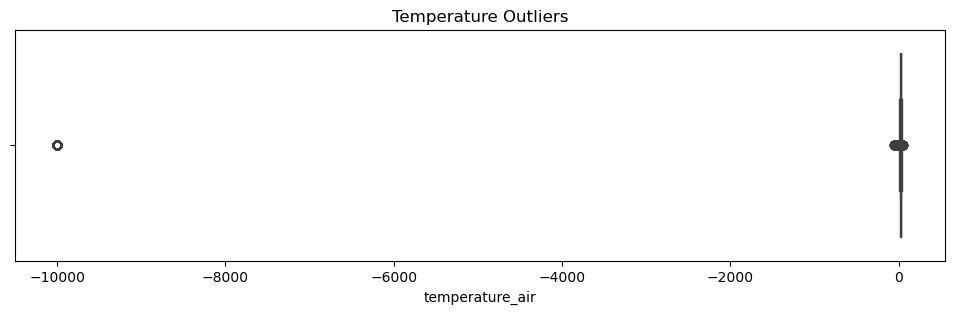

In [ ]:
plt.figure(figsize=(12, 3))
sns.boxplot(x=weather['temperature_air'])
plt.title('Temperature Outliers')
plt.show()

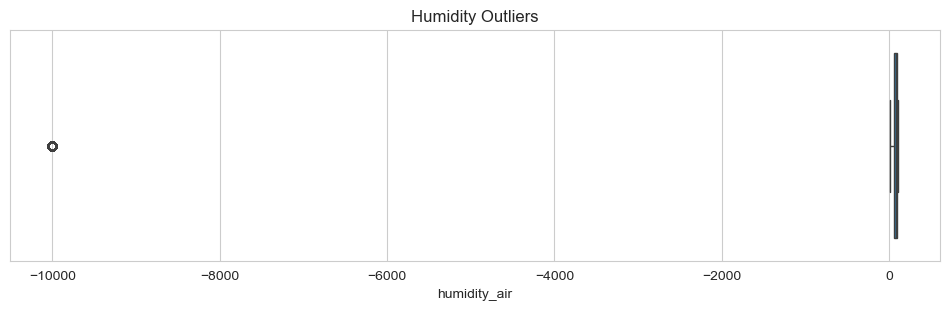

In [ ]:
plt.figure(figsize=(12, 3))
sns.boxplot(x=weather['humidity_air'])
plt.title('Humidity Outliers')
plt.show()

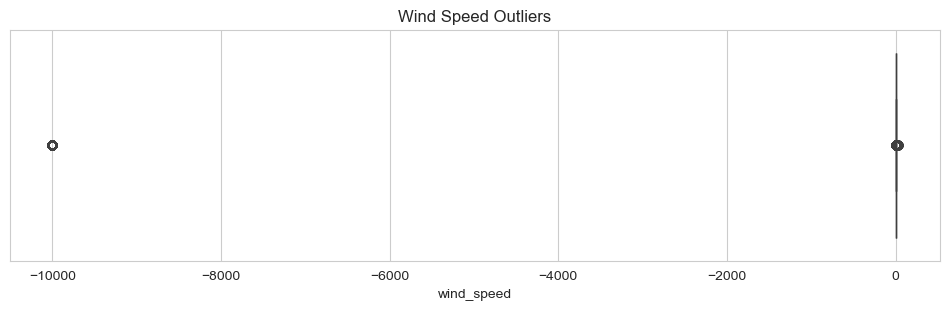

In [ ]:
plt.figure(figsize=(12, 3))
sns.boxplot(x=weather['wind_speed'])
plt.title('Wind Speed Outliers')
plt.show()

In [ ]:
weather.replace(-9999, np.nan, inplace=True)
weather.fillna(method='ffill', inplace=True)

C:\Users\chbha\AppData\Local\Temp\ipykernel_26268\1828085665.py:2: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  weather.fillna(method='ffill', inplace=True)


In [ ]:
sns.set_style('whitegrid')

In [ ]:
non_numeric_cols = weather.select_dtypes(exclude=['number']).columns

label_encoders = {}
for col in non_numeric_cols:
    le = LabelEncoder()
    weather[col] = le.fit_transform(weather[col].astype(str))
    label_encoders[col] = le

**Visualize distributions of key features**

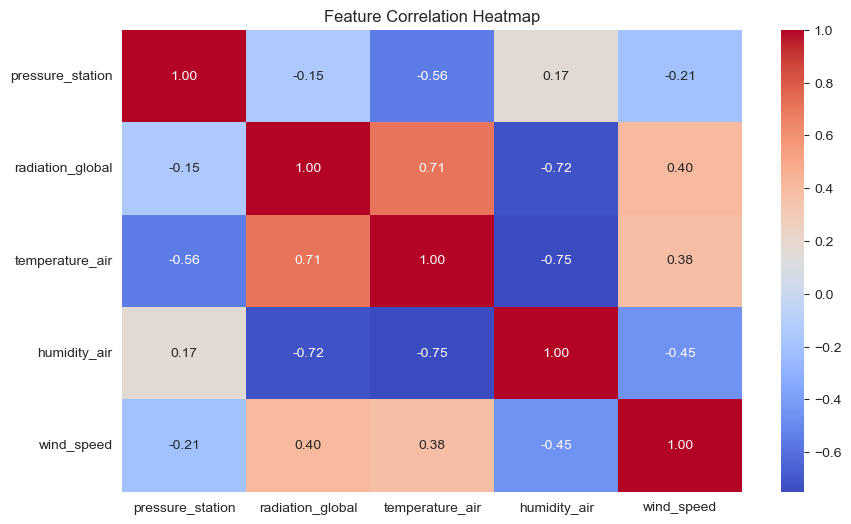

In [ ]:
plt.figure(figsize=(10, 6))
sns.heatmap(weather.corr(), annot=True, cmap='coolwarm', fmt='.2f')
plt.title("Feature Correlation Heatmap")
plt.show()

**Create time series plots for temperature, humidity, and wind speed**

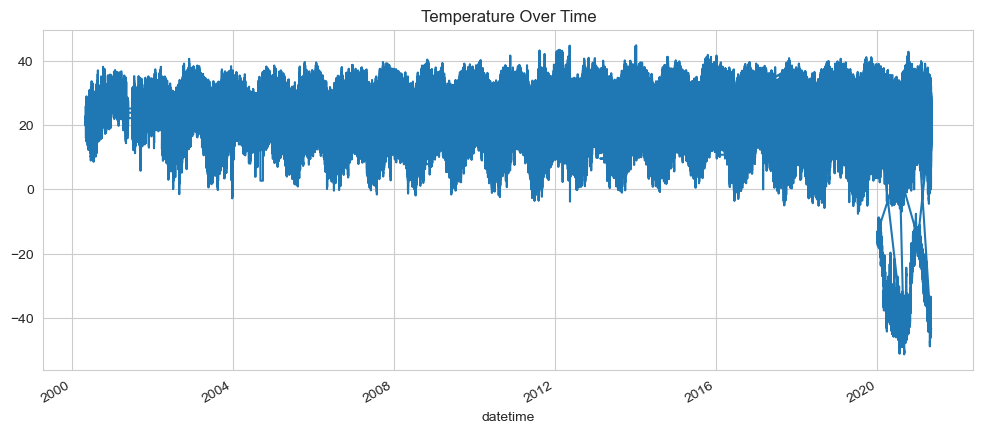

In [ ]:
plt.figure(figsize=(12, 5))
weather['temperature_air'].plot(title='Temperature Over Time')
plt.show()

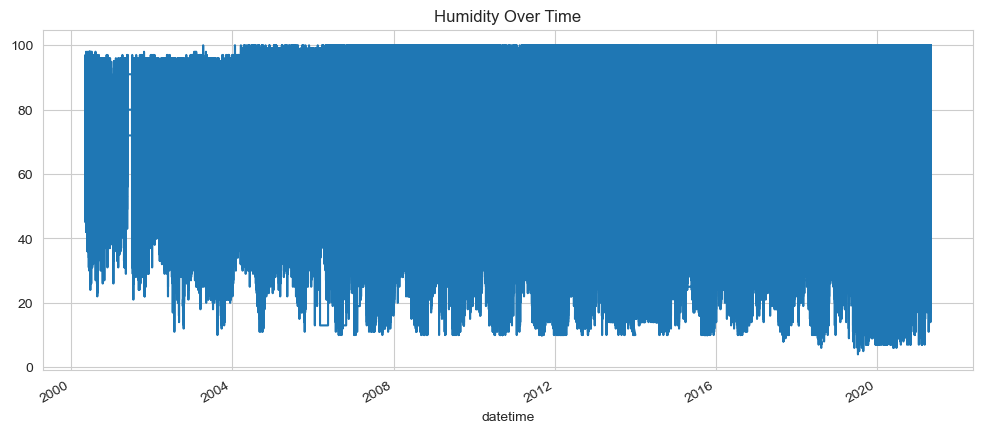

In [ ]:
mpl.rcParams['agg.path.chunksize'] = 10000
plt.figure(figsize=(12, 5))
weather['humidity_air'].plot(title='Humidity Over Time')
plt.show()

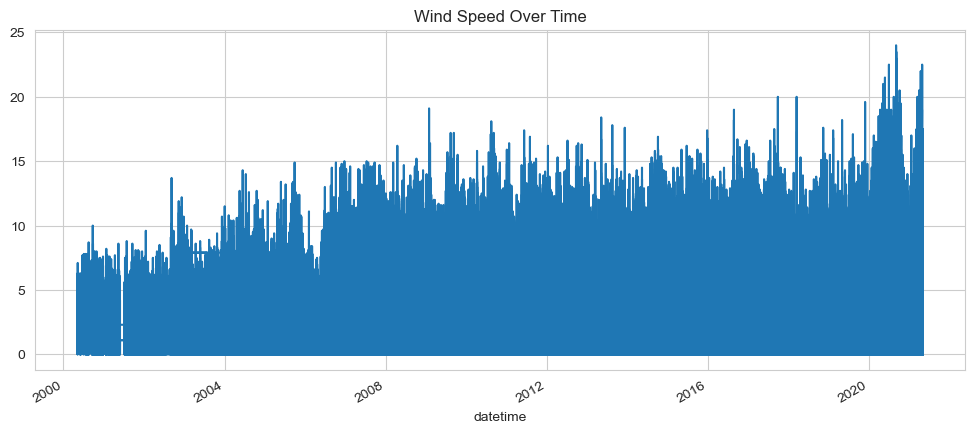

In [ ]:
plt.figure(figsize=(12, 5))
weather['wind_speed'].plot(title='Wind Speed Over Time')
plt.show()

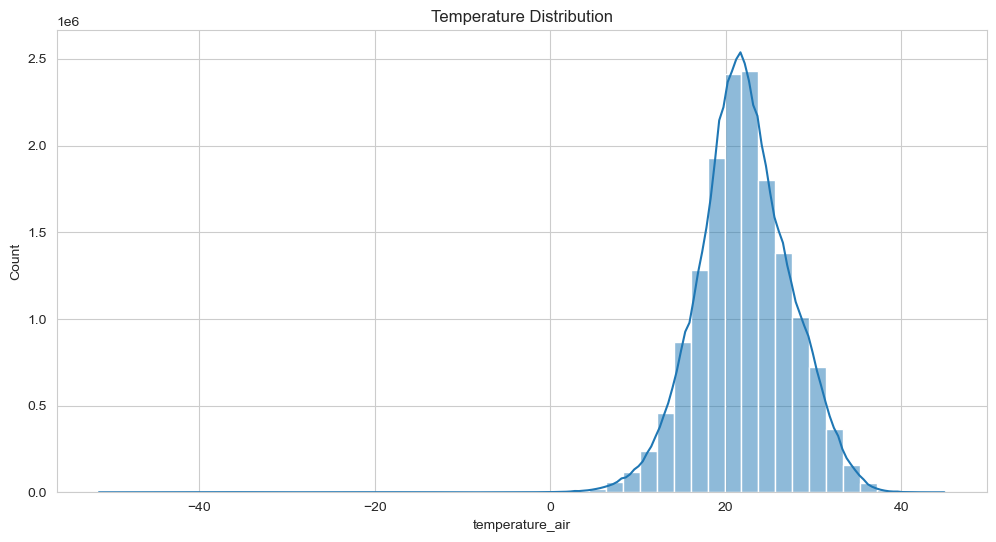

In [ ]:
plt.figure(figsize=(12, 6))
sns.histplot(weather['temperature_air'], bins=50, kde=True)
plt.title("Temperature Distribution")
plt.show()

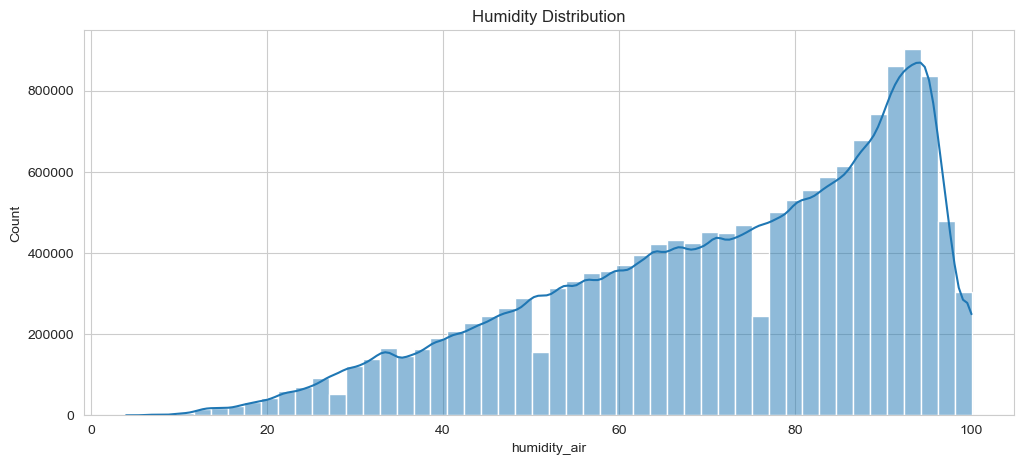

In [ ]:
plt.figure(figsize=(12, 5))
sns.histplot(weather['humidity_air'], bins=50, kde=True)
plt.title('Humidity Distribution')
plt.show()


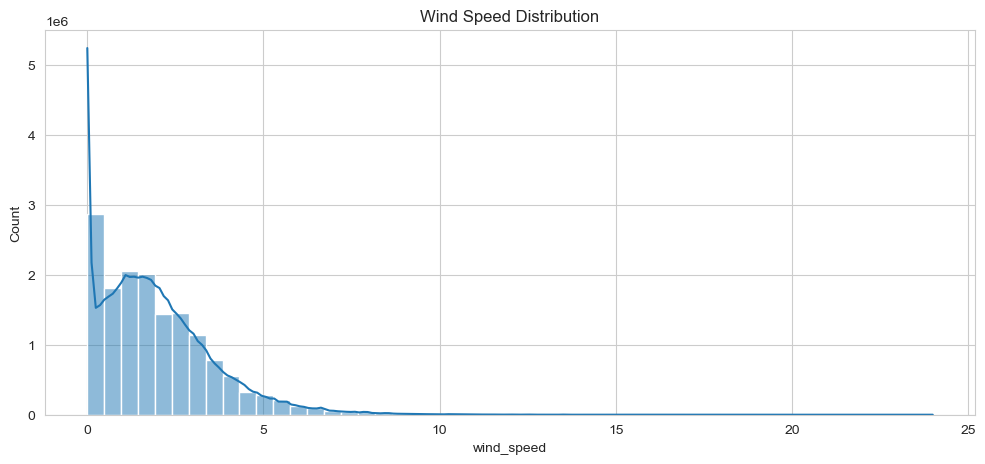

In [ ]:
plt.figure(figsize=(12, 5))
sns.histplot(weather['wind_speed'], bins=50, kde=True)
plt.title('Wind Speed Distribution')
plt.show()


## Preprocess the Data

**Handling Missing Values**

In [ ]:
weather['radiation_global'].fillna(0, inplace=True)

weather.fillna(weather.median(), inplace=True)


C:\Users\chbha\AppData\Local\Temp\ipykernel_26268\989770043.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  weather['radiation_global'].fillna(0, inplace=True)


In [ ]:
weather.head()

,pressure_station,radiation_global,temperature_air,humidity_air,wind_speed
datetime,,,,,
2000-05-07 00:00:00,1011.9,0.0,23.3,84.0,1.7
2000-05-07 01:00:00,1011.9,0.0,23.3,84.0,1.7
2000-05-07 02:00:00,1011.9,0.0,23.3,84.0,1.7
2000-05-07 03:00:00,1011.9,0.0,23.3,84.0,1.7
2000-05-07 04:00:00,1011.9,0.0,23.3,84.0,1.7


**Normalize/standardize features**

In [ ]:
features = ['temperature_air', 'humidity_air', 'wind_speed', 'pressure_station', 'radiation_global']

scaler = StandardScaler()
for feature in features:
    weather[feature] = scaler.fit_transform(weather[feature].values.reshape(-1, 1))

In [ ]:
weather.head()

,pressure_station,radiation_global,temperature_air,humidity_air,wind_speed,station,latitude,longitude
datetime,,,,,,,,
2000-05-07 00:00:00,-0.005134,-0.468095,-0.010271,0.195781,-0.156191,47,-22.8,-43.683333
2000-05-07 01:00:00,-0.005134,-0.468095,-0.010271,0.195781,-0.156191,47,-22.8,-43.683333
2000-05-07 02:00:00,-0.005134,-0.468095,-0.010271,0.195781,-0.156191,47,-22.8,-43.683333
2000-05-07 03:00:00,-0.005134,-0.468095,-0.010271,0.195781,-0.156191,47,-22.8,-43.683333
2000-05-07 04:00:00,-0.005134,-0.468095,-0.010271,0.195781,-0.156191,47,-22.8,-43.683333


**Create sequences for time series forecasting**

In [ ]:
def create_sequences(data, input_cols, target_cols, window_size, forecast_horizon):
    datetime_values = data["datetime"].values[window_size:-forecast_horizon]

    input_cols_filtered = [col for col in input_cols if col != "datetime"]
    data_array = data[input_cols_filtered + target_cols].values
    num_samples = len(data_array) - window_size - forecast_horizon + 1

    X = np.array([data_array[i : i + window_size, :len(input_cols_filtered)] for i in range(num_samples)], dtype=np.float32)
    y = np.array([data_array[i + window_size : i + window_size + forecast_horizon, len(input_cols_filtered):] for i in range(num_samples)], dtype=np.float32)

    return X, y, datetime_values


In [ ]:
input_cols = ['datetime','temperature_air', 'humidity_air', 'wind_speed', 'pressure_station', 'radiation_global']
target_cols = ['temperature_air', 'humidity_air', 'wind_speed', 'pressure_station', 'radiation_global']

window_size = 24

weather = weather.reset_index()
weather = weather.sort_values('datetime')

print(weather[-1:])

X, y, datetime_values = create_sequences(weather, input_cols, target_cols, window_size=24, forecast_horizon=6)

        level_0   index            datetime  pressure_station  \
163511   163511  163511 2018-12-31 23:00:00         -0.610329   

        radiation_global  temperature_air  humidity_air  wind_speed  
163511         -0.503913         0.100365     -0.000233    -0.31736  


**Split into training, validation, and test sets**

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, shuffle=False)

print(f"Train shape: {X_train.shape}, {y_train.shape}")
print(f'Validation shape: {X_val.shape}, {y_val.shape}')
print(f'Test shape: {X_test.shape}, {y_test.shape}')


Train shape: (117707, 24, 5), (117707, 6, 5)
Validation shape: (13079, 24, 5), (13079, 6, 5)
Test shape: (32697, 24, 5), (32697, 6, 5)


In [ ]:
X_train_flat = torch.tensor(X_train.reshape(len(X_train), -1), dtype=torch.float32).to(device)
X_val_flat = torch.tensor(X_val.reshape(len(X_val), -1), dtype=torch.float32).to(device)
dataset = TensorDataset(X_train_flat)
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

# Part 2: VAE Implementation for Anomaly Detection

## Implement a VAE architecture with:

**An encoder with at least 2 hidden layers**

**A latent space dimension of your choice (justify your selection)**

**A decoder with at least 2 hidden layers**

**Proper sampling from the latent distribution**

**Justification for Latent Space Dimension:**

The latent space dimension is set to 8. This provides a balance between compression and information retention, ensuring the model can reconstruct weather data effectively while capturing key variations.

In [ ]:
class VAE(nn.Module):
    def __init__(self, input_dim, latent_dim=16):
        super(VAE, self).__init__()

        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 256),
            nn.LeakyReLU(0.2),
            nn.BatchNorm1d(256),
            nn.Dropout(0.1),
            nn.Linear(256, 128),
            nn.LeakyReLU(0.2),
            nn.BatchNorm1d(128),
            nn.Linear(128, 64),
            nn.LeakyReLU(0.2)
        )

        self.fc_mu = nn.Linear(64, latent_dim)
        self.fc_logvar = nn.Linear(64, latent_dim)

        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 64),
            nn.LeakyReLU(0.2),
            nn.Linear(64, 128),
            nn.LeakyReLU(0.2),
            nn.BatchNorm1d(128),
            nn.Linear(128, 256),
            nn.LeakyReLU(0.2),
            nn.BatchNorm1d(256),
            nn.Linear(256, input_dim),
            nn.Sigmoid()
        )

        self.apply(self._weights_init)

    def encode(self, x):
        h = self.encoder(x)
        mu = self.fc_mu(h)
        logvar = self.fc_logvar(h)
        return mu, logvar

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        return self.decoder(z)

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        recon_x = self.decode(z)
        return recon_x, mu, logvar

    def _weights_init(self, m):
        if isinstance(m, nn.Linear):
            nn.init.xavier_uniform_(m.weight)
            if m.bias is not None:
                nn.init.zeros_(m.bias)


In [ ]:
input_dim = X_train.shape[1] * X_train.shape[2]
latent_dim = 8
vae = VAE(input_dim, latent_dim).to(device)

## Train the VAE on normal weather patterns:

**Use appropriate loss functions (reconstruction loss + KL divergence)**

**Implement early stopping**

**Visualize the training and validation loss curves**

In [ ]:
def loss_function(reconstructed, x, mu, log_var):
    reconstruction_loss = F.mse_loss(reconstructed, x, reduction='sum')
    kl_divergence = -0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())
    return reconstruction_loss + kl_divergence

In [ ]:
optimizer = optim.Adam(vae.parameters(), lr=1e-3)
epochs = 100
early_stopping_patience = 10
best_loss = np.inf
patience_counter = 0
train_losses, val_losses = [], []

In [ ]:
for epoch in range(epochs):
    vae.train()
    train_loss = 0
    for batch in dataloader:
        optimizer.zero_grad()
        x_batch = batch[0]
        reconstructed, mu, log_var = vae(x_batch)
        loss = loss_function(reconstructed, x_batch, mu, log_var)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

    vae.eval()
    with torch.no_grad():
        reconstructed, mu, log_var = vae(X_val_flat)
        val_loss = loss_function(reconstructed, X_val_flat, mu, log_var).item()

    train_losses.append(train_loss / len(dataloader))
    val_losses.append(val_loss)
    print(f"Epoch {epoch+1}, Train Loss: {train_losses[-1]:.4f}, Val Loss: {val_losses[-1]:.4f}")

    if val_loss < best_loss:
        best_loss = val_loss
        patience_counter = 0
    else:
        patience_counter += 1
        if patience_counter >= early_stopping_patience:
            print("Early stopping triggered.")
            break

Epoch 1, Train Loss: 2675.3648, Val Loss: 1086888.6250
Epoch 2, Train Loss: 2603.4677, Val Loss: 1080712.8750
Epoch 3, Train Loss: 2591.1870, Val Loss: 1080410.8750
Epoch 4, Train Loss: 2582.3363, Val Loss: 1078963.5000
Epoch 5, Train Loss: 2576.2747, Val Loss: 1077374.6250
Epoch 6, Train Loss: 2571.2937, Val Loss: 1075889.5000
Epoch 7, Train Loss: 2566.8037, Val Loss: 1075288.5000
Epoch 8, Train Loss: 2564.2454, Val Loss: 1074315.0000
Epoch 9, Train Loss: 2562.2119, Val Loss: 1073412.3750
Epoch 10, Train Loss: 2560.1177, Val Loss: 1069665.0000
Epoch 11, Train Loss: 2557.9017, Val Loss: 1070881.8750
Epoch 12, Train Loss: 2556.5236, Val Loss: 1070027.0000
Epoch 13, Train Loss: 2555.2853, Val Loss: 1069716.6250
Epoch 14, Train Loss: 2554.0240, Val Loss: 1071529.6250
Epoch 15, Train Loss: 2552.9855, Val Loss: 1070686.1250
Epoch 16, Train Loss: 2551.9482, Val Loss: 1069730.5000
Epoch 17, Train Loss: 2550.2481, Val Loss: 1069850.3750
Epoch 18, Train Loss: 2550.3999, Val Loss: 1070019.5000
E

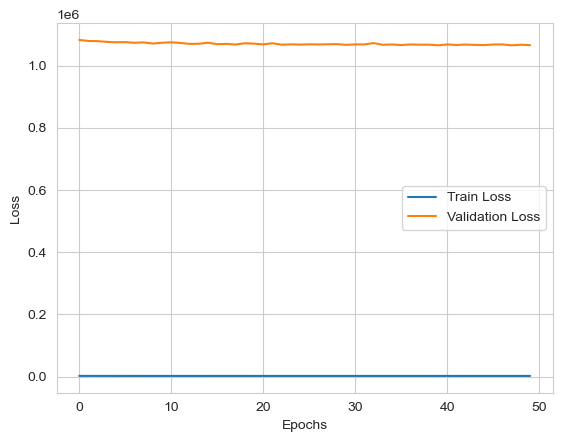

In [ ]:
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

## Anomaly detection:

**Define an anomaly score based on reconstruction error**

**Detect anomalous weather days (e.g., extreme temperature changes)**

**Visualize the anomalies on a time series plot**

**Evaluate your anomaly detection performance using precision, recall, and F1-score**

**Consider different threshold values for anomaly detection and justify your choice**

In [ ]:
vae.eval()
X_test_flat = torch.tensor(X_test.reshape(len(X_test), -1), dtype=torch.float32).to(device)
with torch.no_grad():
    reconstructed, _, _ = vae(X_test_flat)
    reconstruction_errors = torch.mean((X_test_flat - reconstructed) ** 2, dim=1).cpu().numpy()

In [ ]:
threshold = np.percentile(reconstruction_errors, 95)
anomalies = reconstruction_errors > threshold

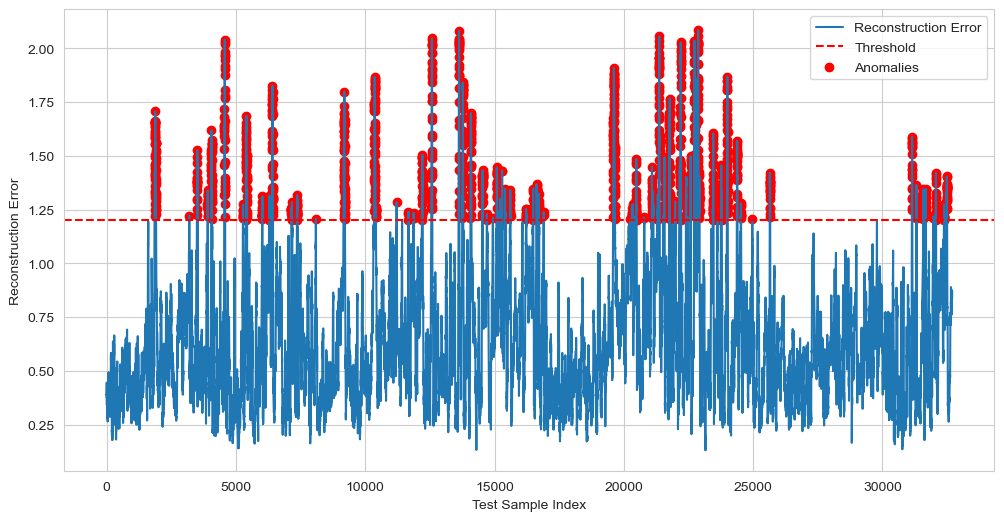

In [ ]:
plt.figure(figsize=(12, 6))
plt.plot(reconstruction_errors, label='Reconstruction Error')
plt.axhline(y=threshold, color='r', linestyle='--', label='Threshold')
plt.scatter(np.where(anomalies)[0], reconstruction_errors[anomalies], color='red', label='Anomalies')
plt.legend()
plt.xlabel('Test Sample Index')
plt.ylabel('Reconstruction Error')
plt.show()

In [ ]:
threshold = np.percentile(reconstruction_errors, 99)
anomalies = reconstruction_errors > threshold

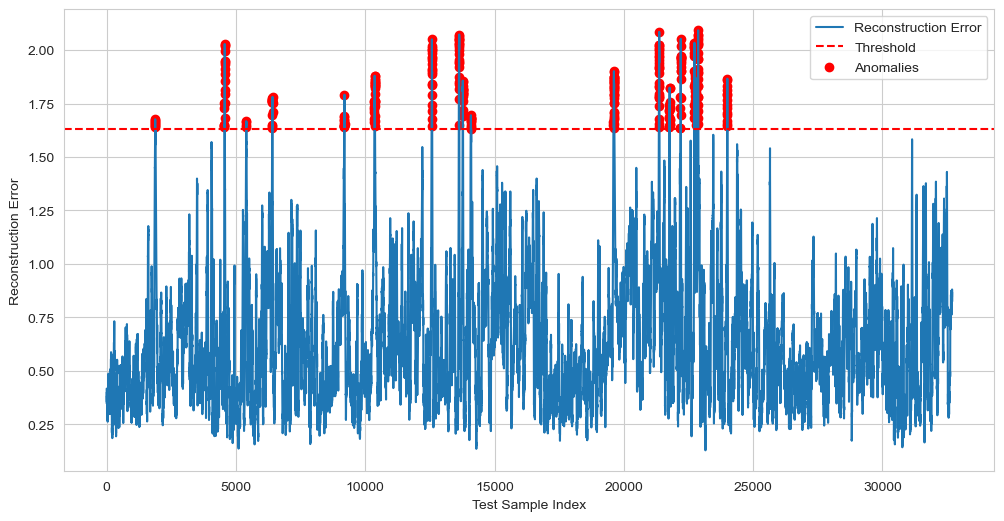

In [ ]:
plt.figure(figsize=(12, 6))
plt.plot(reconstruction_errors, label='Reconstruction Error')
plt.axhline(y=threshold, color='r', linestyle='--', label='Threshold')
plt.scatter(np.where(anomalies)[0], reconstruction_errors[anomalies], color='red', label='Anomalies')
plt.legend()
plt.xlabel('Test Sample Index')
plt.ylabel('Reconstruction Error')
plt.show()

In [ ]:
threshold = np.percentile(reconstruction_errors, 75)
anomalies = reconstruction_errors > threshold

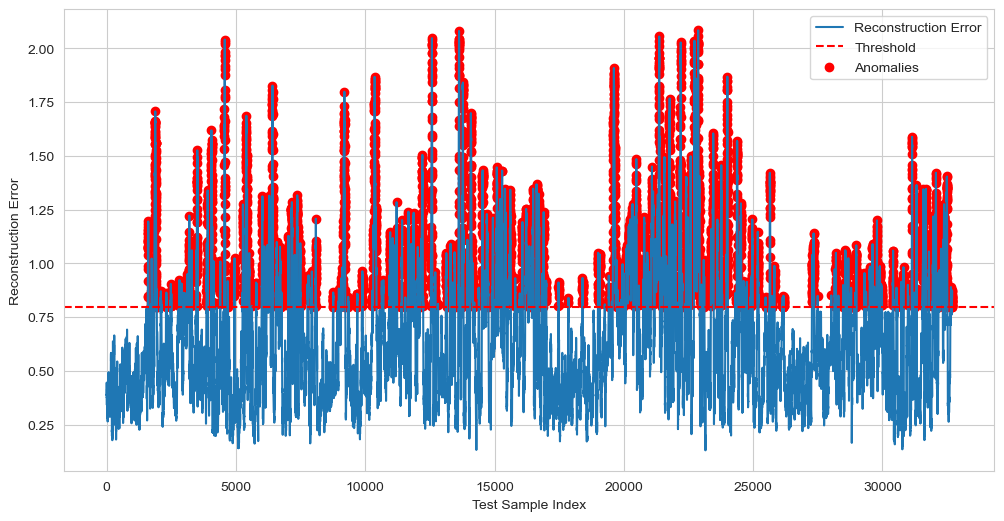

In [ ]:
plt.figure(figsize=(12, 6))
plt.plot(reconstruction_errors, label='Reconstruction Error')
plt.axhline(y=threshold, color='r', linestyle='--', label='Threshold')
plt.scatter(np.where(anomalies)[0], reconstruction_errors[anomalies], color='red', label='Anomalies')
plt.legend()
plt.xlabel('Test Sample Index')
plt.ylabel('Reconstruction Error')
plt.show()

In [ ]:
threshold = np.percentile(reconstruction_errors, 90)
anomalies = reconstruction_errors > threshold

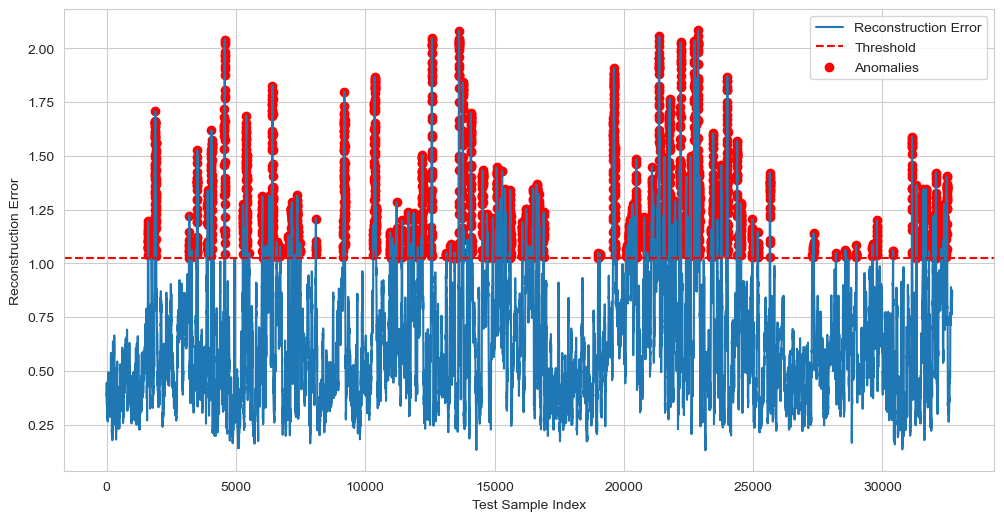

In [ ]:
plt.figure(figsize=(12, 6))
plt.plot(reconstruction_errors, label='Reconstruction Error')
plt.axhline(y=threshold, color='r', linestyle='--', label='Threshold')
plt.scatter(np.where(anomalies)[0], reconstruction_errors[anomalies], color='red', label='Anomalies')
plt.legend()
plt.xlabel('Test Sample Index')
plt.ylabel('Reconstruction Error')
plt.show()

In [ ]:
threshold = np.percentile(reconstruction_errors, 40)
anomalies = reconstruction_errors > threshold

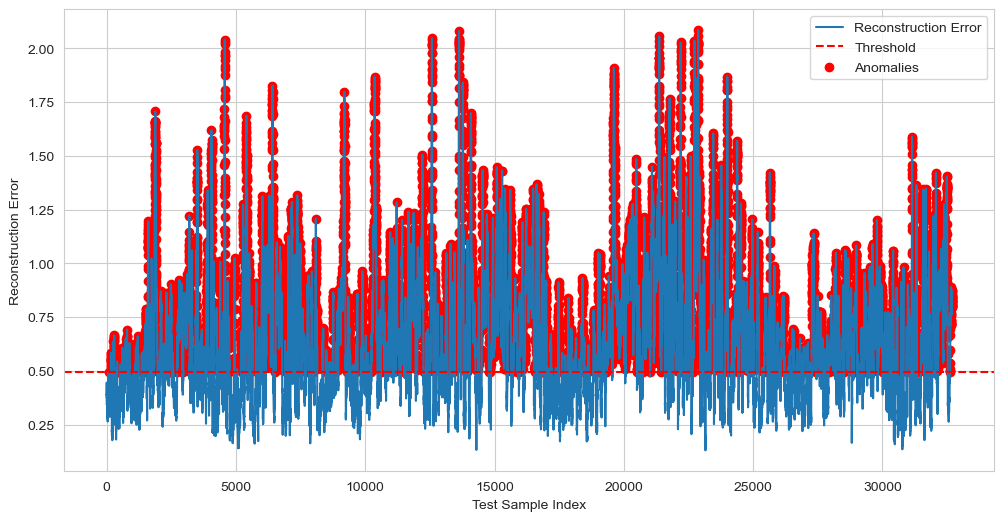

In [ ]:
plt.figure(figsize=(12, 6))
plt.plot(reconstruction_errors, label='Reconstruction Error')
plt.axhline(y=threshold, color='r', linestyle='--', label='Threshold')
plt.scatter(np.where(anomalies)[0], reconstruction_errors[anomalies], color='red', label='Anomalies')
plt.legend()
plt.xlabel('Test Sample Index')
plt.ylabel('Reconstruction Error')
plt.show()

**Best is (95, 99, 75, 90, 40):** 75-95% is better range

**Justification for Threshold Choice**

Higher percentiles (99%) detect extreme anomalies but may miss some subtle anomalies. There are not too many false negatives (missed anomalies).

Lower percentiles (40%) detect more anomalies but may cause false positives. There are not too many false positives (normal points above the threshold).

## 4. Latent space analysis:

**Visualize the latent space (use dimensionality reduction if needed)**

**Analyze how different weather patterns are represented in the latent space**

**Generate new synthetic weather data by sampling from the latent space**

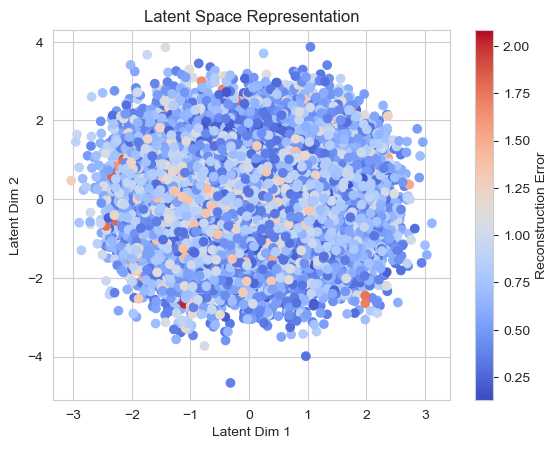

In [ ]:
with torch.no_grad():
    mu, logvar = vae.encode(X_test_flat)
    z = vae.reparameterize(mu, logvar).cpu().numpy()

pca = PCA(n_components=2)
z_pca = pca.fit_transform(z)
plt.scatter(z_pca[:, 0], z_pca[:, 1], c=reconstruction_errors, cmap='coolwarm')
plt.colorbar(label='Reconstruction Error')
plt.xlabel('Latent Dim 1')
plt.ylabel('Latent Dim 2')
plt.title('Latent Space Representation')
plt.show()

In [ ]:
z_samples = torch.randn(10, latent_dim).to(device)
with torch.no_grad():
    synthetic_data = vae.decoder(z_samples).cpu().numpy()
print("Synthetic Weather Data Samples:")
print(synthetic_data)

Synthetic Weather Data Samples:
[[2.36392347e-03 4.70039338e-01 1.91306455e-07 ... 1.18940789e-02
  2.02858285e-03 2.86978920e-05]
 [5.14095902e-01 2.50695776e-02 3.66248004e-02 ... 4.92740981e-02
  3.14278282e-06 7.40290154e-03]
 [5.91237551e-07 9.29365277e-01 1.02374338e-06 ... 4.74623012e-05
  9.52859938e-01 2.62466227e-08]
 ...
 [1.45790864e-06 9.84932601e-01 9.19535705e-06 ... 1.29323835e-05
  4.92967278e-01 1.76345523e-07]
 [7.59580359e-07 8.43050957e-01 4.26904904e-07 ... 1.09989458e-04
  5.52736759e-01 1.63080003e-08]
 [1.87145531e-06 9.42122698e-01 1.81962096e-05 ... 2.01671501e-03
  7.22990513e-01 3.71778924e-07]]


# Part 3: GRU Implementation for Time Series Forecasting

## Implement a GRU-based network:

**Input features should include multiple weather metrics**

**At least one GRU layer with justified number of units**

**Appropriate output layer for forecasting**

In [ ]:
class GRUModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, num_layers=1, forecast_horizon=6, dropout=0.2):
        super(GRUModel, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        self.forecast_horizon = forecast_horizon

        self.gru = nn.GRU(input_dim, hidden_dim, num_layers, batch_first=True, dropout=dropout)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.shape[0], self.hidden_dim).to(x.device)
        out, _ = self.gru(x, h0)

        out = out[:, -self.forecast_horizon:, :]
        return self.fc(out)


## Configure the model for sequence-to-sequence forecasting:

**Use past N hours to predict the next M hours (choose appropriate N and M)**

**Implement teacher forcing during training (with a decay schedule)**

In [ ]:
def train_gru(model, train_loader, val_loader, num_epochs=50, patience=5, teacher_forcing_prob=0.5, lr=0.001):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.8)

    train_losses, val_losses = [], []
    best_val_loss = float('inf')
    early_stopping_counter = 0

    for epoch in range(num_epochs):
        model.train()
        epoch_loss = 0

        for inputs, targets in train_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            # targets = targets.view(targets.shape[0], 6, 5)

            loss = criterion(outputs, targets)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()

        scheduler.step()

        model.eval()
        val_loss = 0
        with torch.no_grad():
            for inputs, targets in val_loader:
                inputs, targets = inputs.to(device), targets.to(device)
                outputs = model(inputs)
                val_loss += criterion(outputs, targets).item()

        train_losses.append(epoch_loss / len(train_loader))
        val_losses.append(val_loss / len(val_loader))

        print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_losses[-1]:.4f}, Val Loss: {val_losses[-1]:.4f}")

        if val_losses[-1] < best_val_loss:
            best_val_loss = val_losses[-1]
            early_stopping_counter = 0
        else:
            early_stopping_counter += 1

        if early_stopping_counter >= patience:
            print(f"Early stopping triggered after {epoch+1} epochs.")
            break

    return train_losses, val_losses

## Train the GRU model:

**Implement batch training**

**Use an appropriate loss function for regression**

**Implement learning rate scheduling**

**Visualize training and validation loss**

In [ ]:
seq_len = 24
input_dim = 5

In [ ]:
batch_size = 64

train_loader = DataLoader(TensorDataset(torch.tensor(X_train, dtype=torch.float32),
                                        torch.tensor(y_train, dtype=torch.float32)),
                          batch_size=batch_size, shuffle=True)

val_loader = DataLoader(TensorDataset(torch.tensor(X_val, dtype=torch.float32),
                                      torch.tensor(y_val, dtype=torch.float32)),
                        batch_size=batch_size, shuffle=False)

test_loader = DataLoader(TensorDataset(torch.tensor(X_test, dtype=torch.float32),
                                       torch.tensor(y_test, dtype=torch.float32)),
                         batch_size=batch_size, shuffle=False)


In [ ]:
model = GRUModel(input_dim=5, hidden_dim=64, output_dim=5, num_layers=2, forecast_horizon=6)
train_losses, val_losses = train_gru(model, dataloader, val_loader, num_epochs=50, lr=0.001)

Epoch 1/50, Train Loss: 0.2834, Val Loss: 0.2654
Epoch 2/50, Train Loss: 0.2389, Val Loss: 0.2548
Epoch 3/50, Train Loss: 0.2273, Val Loss: 0.2397
Epoch 4/50, Train Loss: 0.2200, Val Loss: 0.2422
Epoch 5/50, Train Loss: 0.2139, Val Loss: 0.2439
Epoch 6/50, Train Loss: 0.2088, Val Loss: 0.2422
Epoch 7/50, Train Loss: 0.2037, Val Loss: 0.2448
Epoch 8/50, Train Loss: 0.1995, Val Loss: 0.2487
Early stopping triggered after 8 epochs.


## Evaluate forecasting performance:

**Compute MSE, MAE, and RMSE on the test set**

**Visualize predictions vs. actual values**

**Analyze how far into the future the model can predict accurately**

In [ ]:
X_test_flat = torch.tensor(X_test.reshape(len(X_test), -1), dtype=torch.float32).to(device)
y_test_flat = torch.tensor(y_test.reshape(len(y_test), -1), dtype=torch.float32).to(device)
X_test_flat = X_test_flat.view(len(X_test_flat), seq_len, input_dim).to(device)

test_dataset = TensorDataset(X_test_flat, y_test_flat)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=True)

## Ablation study:

**Compare GRU performance to a simpler LSTM and RNN**

**Analyze how changing the sequence length affects performance**

**Investigate how different features impact prediction accuracy**

Output shape: (32697,), Target shape: (32697,)
MSE: 0.2382, MAE: 0.3625, RMSE: 0.4881


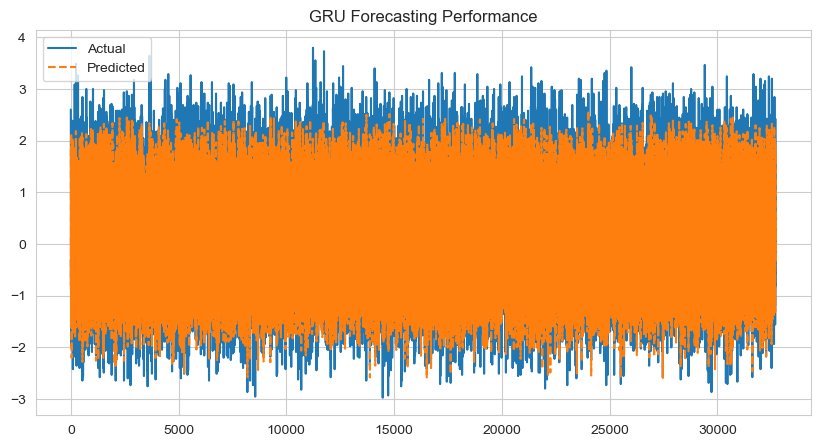

In [ ]:
def evaluate_model(model, test_loader):
    model.eval()
    preds, actuals = [], []

    with torch.no_grad():
        for inputs, targets in test_loader:
            inputs = inputs.to(device)
            outputs = model(inputs).cpu().numpy()
            preds.extend(outputs[:, 0, 0])
            targets = targets.cpu().numpy()
            # targets = targets.view(targets.shape[0], 6, 5).cpu().numpy()
            actuals.extend(targets[:, 0])

    preds, actuals = np.array(preds), np.array(actuals)
    print(f"Output shape: {preds.shape}, Target shape: {actuals.shape}")

    mse = mean_squared_error(actuals, preds)
    mae = mean_absolute_error(actuals, preds)
    rmse = np.sqrt(mse)

    print(f"MSE: {mse:.4f}, MAE: {mae:.4f}, RMSE: {rmse:.4f}")

    plt.figure(figsize=(10, 5))
    plt.plot(actuals, label="Actual")
    plt.plot(preds, label="Predicted", linestyle="dashed")
    plt.legend()
    plt.title("GRU Forecasting Performance")
    plt.show()

evaluate_model(model, test_loader)


In [ ]:
class LSTMModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, num_layers, forecast_horizon):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim * forecast_horizon)
        self.forecast_horizon = forecast_horizon
        self.output_dim = output_dim

    def forward(self, x):
        out, _ = self.lstm(x)
        out = self.fc(out[:, -1, :])
        return out.view(-1, self.forecast_horizon, self.output_dim)

class RNNModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, num_layers, forecast_horizon):
        super(RNNModel, self).__init__()
        self.rnn = nn.RNN(input_dim, hidden_dim, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim * forecast_horizon)
        self.forecast_horizon = forecast_horizon
        self.output_dim = output_dim

    def forward(self, x):
        out, _ = self.rnn(x)
        out = self.fc(out[:, -1, :])
        return out.view(-1, self.forecast_horizon, self.output_dim)



Training LSTM...
Epoch 1/50, Train Loss: 0.2199, Val Loss: 0.2013
Epoch 2/50, Train Loss: 0.1766, Val Loss: 0.1919
Epoch 3/50, Train Loss: 0.1690, Val Loss: 0.1906
Epoch 4/50, Train Loss: 0.1639, Val Loss: 0.1842
Epoch 5/50, Train Loss: 0.1598, Val Loss: 0.1861
Early stopping triggered after 5 epochs.
Output shape: (32697,), Target shape: (32697,)
MSE: 0.0367, MAE: 0.1342, RMSE: 0.1915


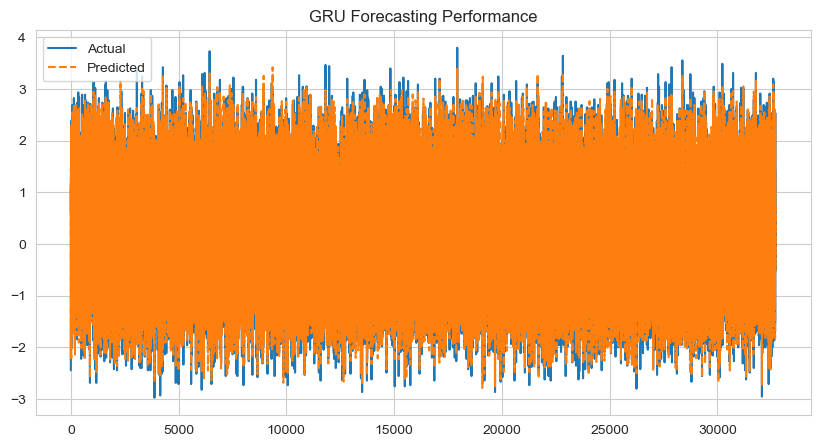


Training RNN...
Epoch 1/50, Train Loss: 0.2287, Val Loss: 0.2223
Epoch 2/50, Train Loss: 0.1968, Val Loss: 0.2099
Epoch 3/50, Train Loss: 0.1913, Val Loss: 0.2075
Epoch 4/50, Train Loss: 0.1865, Val Loss: 0.2060
Epoch 5/50, Train Loss: 0.1835, Val Loss: 0.1995
Epoch 6/50, Train Loss: 0.1836, Val Loss: 0.2081
Early stopping triggered after 6 epochs.
Output shape: (32697,), Target shape: (32697,)
MSE: 0.0421, MAE: 0.1486, RMSE: 0.2052


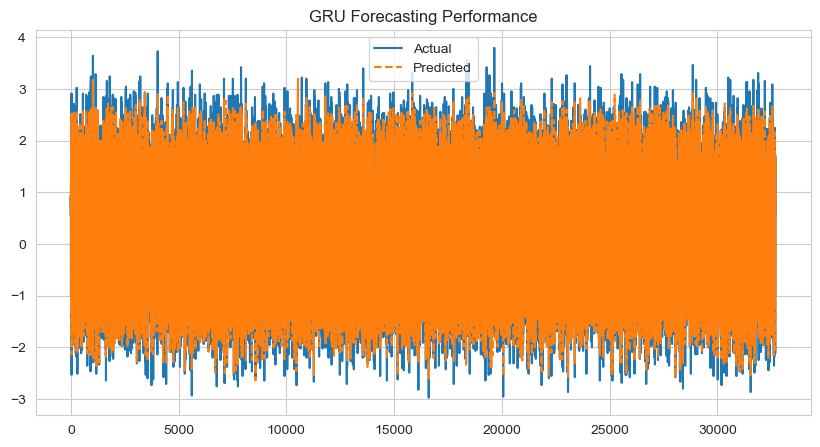

In [ ]:
def train_and_evaluate(model, model_name, dataloader, val_loader, num_epochs=50, lr=0.001):
    print(f"\nTraining {model_name}...")
    train_gru(model, dataloader, val_loader, num_epochs, lr)
    evaluate_model(model, test_loader)

input_dim, hidden_dim, output_dim, num_layers, forecast_horizon = 5, 64, 5, 2, 6

models = {
    "LSTM": LSTMModel(input_dim, hidden_dim, output_dim, num_layers, forecast_horizon),
    "RNN": RNNModel(input_dim, hidden_dim, output_dim, num_layers, forecast_horizon)
}

for name, model in models.items():
    model.to(device)
    train_and_evaluate(model, name, dataloader, val_loader)



Testing with sequence length: 10

Training GRU (Seq=10)...
Epoch 1/50, Train Loss: 0.3987, Val Loss: 0.3418
Epoch 2/50, Train Loss: 0.3133, Val Loss: 0.3306
Epoch 3/50, Train Loss: 0.2925, Val Loss: 0.3133
Epoch 4/50, Train Loss: 0.2809, Val Loss: 0.3025
Epoch 5/50, Train Loss: 0.2727, Val Loss: 0.3021
Epoch 6/50, Train Loss: 0.2669, Val Loss: 0.2920
Epoch 7/50, Train Loss: 0.2624, Val Loss: 0.2911
Epoch 8/50, Train Loss: 0.2590, Val Loss: 0.2907
Epoch 9/50, Train Loss: 0.2556, Val Loss: 0.2916
Early stopping triggered after 9 epochs.
Output shape: (32697,), Target shape: (32697,)
MSE: 0.2231, MAE: 0.3454, RMSE: 0.4724


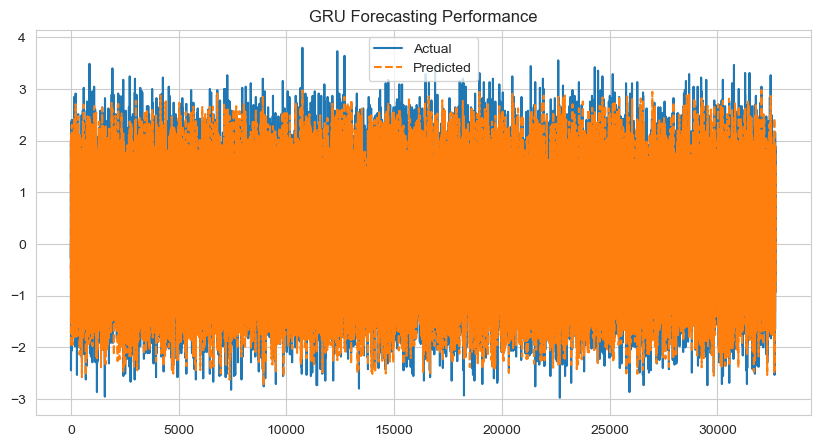


Testing with sequence length: 20

Training GRU (Seq=20)...
Epoch 1/50, Train Loss: 0.3149, Val Loss: 0.2836
Epoch 2/50, Train Loss: 0.2558, Val Loss: 0.2727
Epoch 3/50, Train Loss: 0.2431, Val Loss: 0.2589
Epoch 4/50, Train Loss: 0.2346, Val Loss: 0.2599
Early stopping triggered after 4 epochs.
Output shape: (32697,), Target shape: (32697,)
MSE: 0.1645, MAE: 0.3032, RMSE: 0.4056


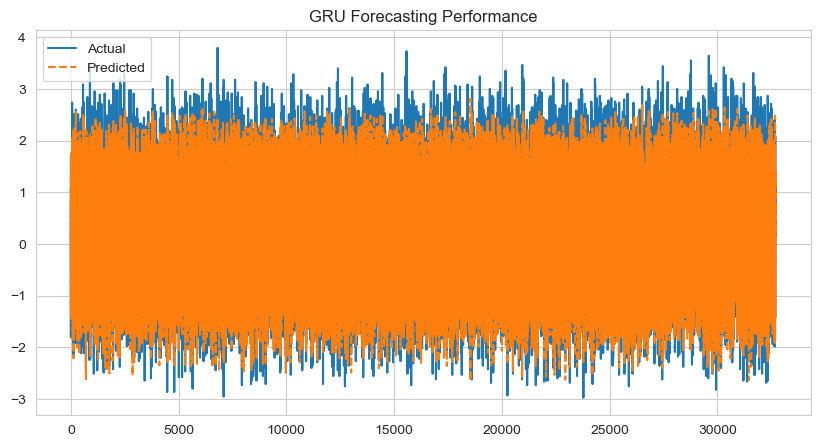


Testing with sequence length: 30

Training GRU (Seq=30)...
Epoch 1/50, Train Loss: 0.2925, Val Loss: 0.2551
Epoch 2/50, Train Loss: 0.2408, Val Loss: 0.2514
Epoch 3/50, Train Loss: 0.2302, Val Loss: 0.2506
Epoch 4/50, Train Loss: 0.2225, Val Loss: 0.2467
Epoch 5/50, Train Loss: 0.2163, Val Loss: 0.2398
Epoch 6/50, Train Loss: 0.2112, Val Loss: 0.2433
Early stopping triggered after 6 epochs.
Output shape: (32697,), Target shape: (32697,)
MSE: 0.2005, MAE: 0.3350, RMSE: 0.4477


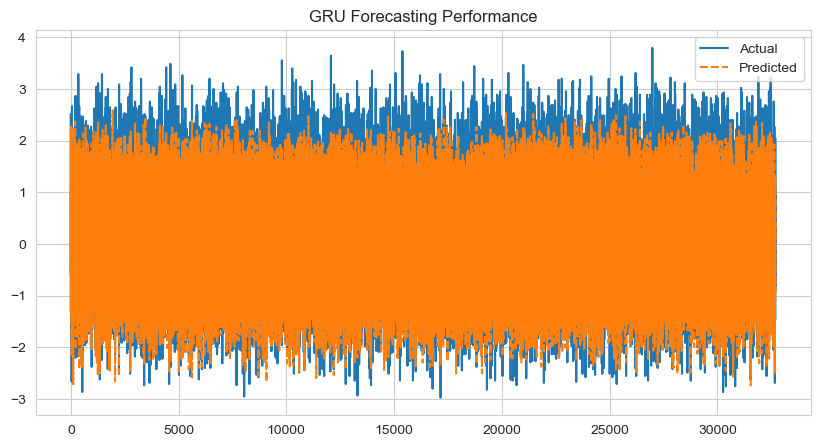

In [ ]:
seq_lengths = [10, 20, 30]

for seq_len in seq_lengths:
    print(f"\nTesting with sequence length: {seq_len}")

    X, y, datetime_values = create_sequences(weather, input_cols, target_cols, window_size=seq_len, forecast_horizon=6)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)
    X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, shuffle=False)

    train_loader = DataLoader(TensorDataset(torch.tensor(X_train, dtype=torch.float32),
                                        torch.tensor(y_train, dtype=torch.float32)),
                          batch_size=batch_size, shuffle=True)

    val_loader = DataLoader(TensorDataset(torch.tensor(X_val, dtype=torch.float32),
                                      torch.tensor(y_val, dtype=torch.float32)),
                        batch_size=batch_size, shuffle=False)

    model = GRUModel(input_dim, hidden_dim, output_dim, num_layers, forecast_horizon).to(device)
    train_and_evaluate(model, f"GRU (Seq={seq_len})", train_loader, val_loader)


Train shape: (117707, 24, 3), (117707, 6, 1)
Validation shape: (13079, 24, 3), (13079, 6, 1)
Test shape: (32697, 24, 3), (32697, 6, 1)
Epoch 1/50, Train Loss: 0.2335, Val Loss: 0.2114
Epoch 2/50, Train Loss: 0.1934, Val Loss: 0.2011
Epoch 3/50, Train Loss: 0.1830, Val Loss: 0.1945
Epoch 4/50, Train Loss: 0.1747, Val Loss: 0.2095
Epoch 5/50, Train Loss: 0.1699, Val Loss: 0.1867
Epoch 6/50, Train Loss: 0.1652, Val Loss: 0.1794
Epoch 7/50, Train Loss: 0.1609, Val Loss: 0.1840
Epoch 8/50, Train Loss: 0.1573, Val Loss: 0.1817
Epoch 9/50, Train Loss: 0.1534, Val Loss: 0.1770
Epoch 10/50, Train Loss: 0.1501, Val Loss: 0.1818
Epoch 11/50, Train Loss: 0.1446, Val Loss: 0.1794
Epoch 12/50, Train Loss: 0.1411, Val Loss: 0.1803
Epoch 13/50, Train Loss: 0.1376, Val Loss: 0.1822
Epoch 14/50, Train Loss: 0.1345, Val Loss: 0.1752
Epoch 15/50, Train Loss: 0.1320, Val Loss: 0.1850
Epoch 16/50, Train Loss: 0.1289, Val Loss: 0.1885
Epoch 17/50, Train Loss: 0.1259, Val Loss: 0.1886
Epoch 18/50, Train Loss:

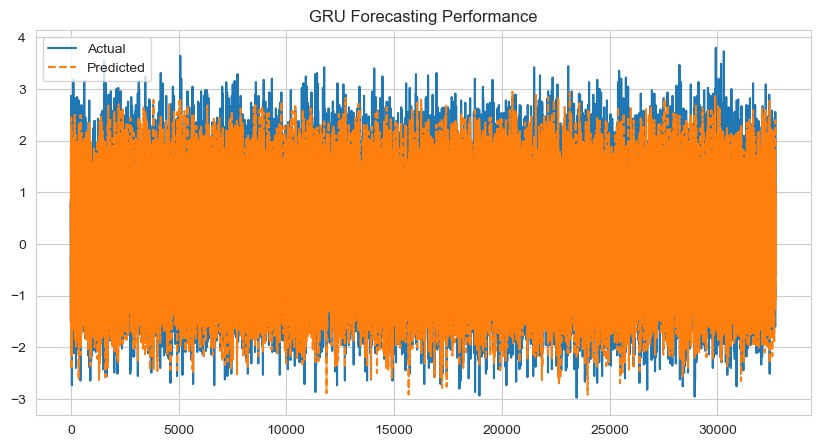

In [ ]:
input_cols = ['datetime','temperature_air', 'humidity_air', 'radiation_global']
target_cols = ['temperature_air']

window_size = 24


X, y, datetime_values = create_sequences(weather, input_cols, target_cols, window_size=24, forecast_horizon=6)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, shuffle=False)

print(f"Train shape: {X_train.shape}, {y_train.shape}")
print(f'Validation shape: {X_val.shape}, {y_val.shape}')
print(f'Test shape: {X_test.shape}, {y_test.shape}')

batch_size = 64

train_loader = DataLoader(TensorDataset(torch.tensor(X_train, dtype=torch.float32),
                                        torch.tensor(y_train, dtype=torch.float32)),
                          batch_size=batch_size, shuffle=True)

val_loader = DataLoader(TensorDataset(torch.tensor(X_val, dtype=torch.float32),
                                      torch.tensor(y_val, dtype=torch.float32)),
                        batch_size=batch_size, shuffle=False)

test_loader = DataLoader(TensorDataset(torch.tensor(X_test, dtype=torch.float32),
                                       torch.tensor(y_test, dtype=torch.float32)),
                         batch_size=batch_size, shuffle=False)

model = GRUModel(input_dim=3, hidden_dim=64, output_dim=1, num_layers=2, forecast_horizon=6)
train_losses, val_losses = train_gru(model, train_loader, val_loader, num_epochs=50, lr=0.001)

input_dim =3
X_test_flat = torch.tensor(X_test.reshape(len(X_test), -1), dtype=torch.float32).to(device)
y_test_flat = torch.tensor(y_test.reshape(len(y_test), -1), dtype=torch.float32).to(device)
X_test_flat = X_test_flat.view(len(X_test_flat), seq_len, input_dim).to(device)

test_dataset = TensorDataset(X_test_flat, y_test_flat)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=True)

evaluate_model(model, test_loader)


Train shape: (117707, 24, 1), (117707, 6, 1)
Validation shape: (13079, 24, 1), (13079, 6, 1)
Test shape: (32697, 24, 1), (32697, 6, 1)
Epoch 1/50, Train Loss: 0.2848, Val Loss: 0.2704
Epoch 2/50, Train Loss: 0.2356, Val Loss: 0.2360
Epoch 3/50, Train Loss: 0.2238, Val Loss: 0.2521
Epoch 4/50, Train Loss: 0.2161, Val Loss: 0.2324
Epoch 5/50, Train Loss: 0.2093, Val Loss: 0.2191
Epoch 6/50, Train Loss: 0.2044, Val Loss: 0.2098
Epoch 7/50, Train Loss: 0.2008, Val Loss: 0.2187
Epoch 8/50, Train Loss: 0.1971, Val Loss: 0.2145
Epoch 9/50, Train Loss: 0.1943, Val Loss: 0.2103
Epoch 10/50, Train Loss: 0.1908, Val Loss: 0.2184
Epoch 11/50, Train Loss: 0.1865, Val Loss: 0.2100
Early stopping triggered after 11 epochs.
Output shape: (32697,), Target shape: (32697,)
MSE: 0.2369, MAE: 0.3594, RMSE: 0.4867


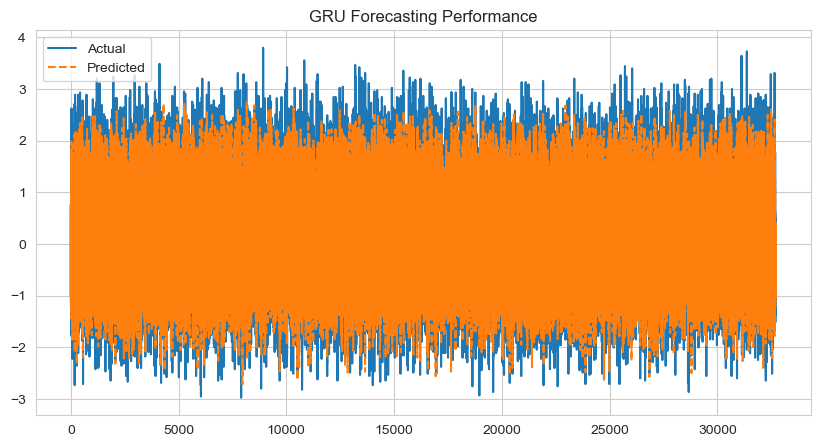

In [ ]:
input_cols = ['datetime','temperature_air']
target_cols = ['temperature_air']

window_size = 24

X, y, datetime_values = create_sequences(weather, input_cols, target_cols, window_size=24, forecast_horizon=6)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, shuffle=False)

print(f"Train shape: {X_train.shape}, {y_train.shape}")
print(f'Validation shape: {X_val.shape}, {y_val.shape}')
print(f'Test shape: {X_test.shape}, {y_test.shape}')

batch_size = 64

train_loader = DataLoader(TensorDataset(torch.tensor(X_train, dtype=torch.float32),
                                        torch.tensor(y_train, dtype=torch.float32)),
                          batch_size=batch_size, shuffle=True)

val_loader = DataLoader(TensorDataset(torch.tensor(X_val, dtype=torch.float32),
                                      torch.tensor(y_val, dtype=torch.float32)),
                        batch_size=batch_size, shuffle=False)

test_loader = DataLoader(TensorDataset(torch.tensor(X_test, dtype=torch.float32),
                                       torch.tensor(y_test, dtype=torch.float32)),
                         batch_size=batch_size, shuffle=False)

model = GRUModel(input_dim=1, hidden_dim=64, output_dim=1, num_layers=2, forecast_horizon=6)
train_losses, val_losses = train_gru(model, train_loader, val_loader, num_epochs=50, lr=0.001)

input_dim = 1
X_test_flat = torch.tensor(X_test.reshape(len(X_test), -1), dtype=torch.float32).to(device)
y_test_flat = torch.tensor(y_test.reshape(len(y_test), -1), dtype=torch.float32).to(device)
X_test_flat = X_test_flat.view(len(X_test_flat), seq_len, input_dim).to(device)

test_dataset = TensorDataset(X_test_flat, y_test_flat)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=True)

evaluate_model(model, test_loader)


Train shape: (117707, 24, 1), (117707, 6, 3)
Validation shape: (13079, 24, 1), (13079, 6, 3)
Test shape: (32697, 24, 1), (32697, 6, 3)
Epoch 1/50, Train Loss: 0.3864, Val Loss: 0.3251
Epoch 2/50, Train Loss: 0.3198, Val Loss: 0.3044
Epoch 3/50, Train Loss: 0.3009, Val Loss: 0.2971
Epoch 4/50, Train Loss: 0.2912, Val Loss: 0.2878
Epoch 5/50, Train Loss: 0.2829, Val Loss: 0.2763
Epoch 6/50, Train Loss: 0.2758, Val Loss: 0.2732
Epoch 7/50, Train Loss: 0.2702, Val Loss: 0.2727
Epoch 8/50, Train Loss: 0.2659, Val Loss: 0.2779
Epoch 9/50, Train Loss: 0.2614, Val Loss: 0.2847
Epoch 10/50, Train Loss: 0.2577, Val Loss: 0.2777
Epoch 11/50, Train Loss: 0.2525, Val Loss: 0.2707
Epoch 12/50, Train Loss: 0.2496, Val Loss: 0.2769
Epoch 13/50, Train Loss: 0.2477, Val Loss: 0.2898
Epoch 14/50, Train Loss: 0.2450, Val Loss: 0.2705
Epoch 15/50, Train Loss: 0.2423, Val Loss: 0.2783
Epoch 16/50, Train Loss: 0.2403, Val Loss: 0.2812
Epoch 17/50, Train Loss: 0.2379, Val Loss: 0.2820
Epoch 18/50, Train Loss:

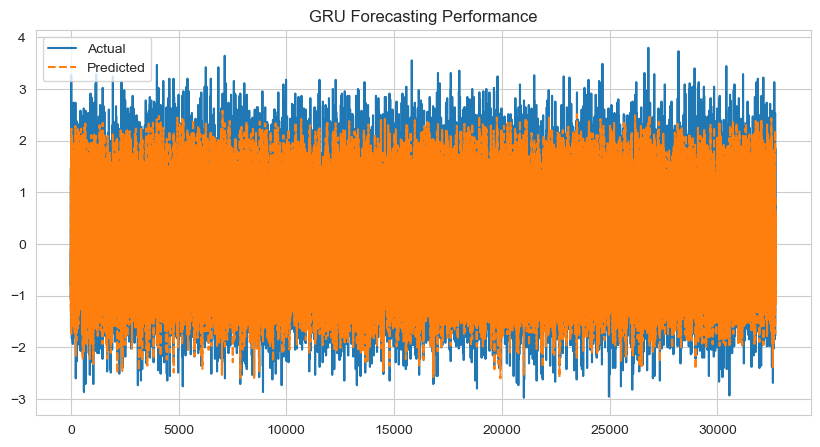

In [ ]:
input_cols = ['datetime','temperature_air']
target_cols = ['temperature_air', 'humidity_air', 'radiation_global']

window_size = 24


X, y, datetime_values = create_sequences(weather, input_cols, target_cols, window_size=24, forecast_horizon=6)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, shuffle=False)

print(f"Train shape: {X_train.shape}, {y_train.shape}")
print(f'Validation shape: {X_val.shape}, {y_val.shape}')
print(f'Test shape: {X_test.shape}, {y_test.shape}')

batch_size = 64

train_loader = DataLoader(TensorDataset(torch.tensor(X_train, dtype=torch.float32),
                                        torch.tensor(y_train, dtype=torch.float32)),
                          batch_size=batch_size, shuffle=True)

val_loader = DataLoader(TensorDataset(torch.tensor(X_val, dtype=torch.float32),
                                      torch.tensor(y_val, dtype=torch.float32)),
                        batch_size=batch_size, shuffle=False)

test_loader = DataLoader(TensorDataset(torch.tensor(X_test, dtype=torch.float32),
                                       torch.tensor(y_test, dtype=torch.float32)),
                         batch_size=batch_size, shuffle=False)

model = GRUModel(input_dim=1, hidden_dim=64, output_dim=3, num_layers=2, forecast_horizon=6)
train_losses, val_losses = train_gru(model, train_loader, val_loader, num_epochs=50, lr=0.001)

input_dim =1
X_test_flat = torch.tensor(X_test.reshape(len(X_test), -1), dtype=torch.float32).to(device)
y_test_flat = torch.tensor(y_test.reshape(len(y_test), -1), dtype=torch.float32).to(device)
X_test_flat = X_test_flat.view(len(X_test_flat), seq_len, input_dim).to(device)

test_dataset = TensorDataset(X_test_flat, y_test_flat)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=True)

evaluate_model(model, test_loader)


**For a GRU(input_dim = 5, output_dim = 5, seq=24):** MSE: 0.1926, MAE: 0.3236, RMSE: 0.4388

**For a LSTM(input_dim = 5, output_dim = 5):** MSE: 0.0367, MAE: 0.1342, RMSE: 0.1915

**For a RNN(input_dim = 5, output_dim = 5):** MSE: 0.0421, MAE: 0.1486, RMSE: 0.2052


**For a GRU(input_dim = 5, output_dim = 5, seq=10):** MSE: 0.2231, MAE: 0.3454, RMSE: 0.4724

**For a GRU(input_dim = 5, output_dim = 5, seq=20):** MSE: 0.1645, MAE: 0.3032, RMSE: 0.4056

**For a GRU(input_dim = 5, output_dim = 5, seq=30):** MSE: 0.2005, MAE: 0.3350, RMSE: 0.4477


**For a GRU(input_dim = 3, output_dim = 1, seq=24):** MSE: 0.2000, MAE: 0.3274, RMSE: 0.4472

**For a GRU(input_dim = 1, output_dim = 1, seq=24):** MSE: 0.2369, MAE: 0.3594, RMSE: 0.4867

**For a GRU(input_dim = 1, output_dim = 3, seq=24):** MSE: 0.2382, MAE: 0.3625, RMSE: 0.4881


**LSTM vs GRU vs RNN**

LSTMs generally perform better than GRUs and RNNs for long-sequence dependencies because they have a separate memory cell that mitigates the vanishing gradient problem. This explains why the LSTM has the lowest error.

GRUs are a simpler version of LSTMs with fewer parameters, making them slightly less effective for long sequences but still much better than RNNs. The higher error compared to LSTM suggests that the dataset might require better long-term memory handling.

RNNs suffer from vanishing gradients, limiting their ability to remember long-term dependencies. However, in some cases (short sequences), they might still perform decently.

**Effect of Sequence Length on GRU Performance**

Seq=10 (MSE: 0.2231, RMSE: 0.4724, MAE: 0.3454) → Highest error

Seq=20 (MSE: 0.1645, RMSE: 0.4056, MAE: 0.3032) → Lower error

Seq=24 (MSE: 0.1926, RMSE: 0.4388, MAE: 0.3236) → Slightly higher than 20

Seq=30 (MSE: 0.2005, RMSE: 0.4477, MAE: 0.3350) → Higher than seq=20

Longer sequences should improve forecasting performance up to a point, but if the sequence is too long, it might introduce noise or redundant information, leading to slightly worse performance.

# Part 4: Model Integration and Analysis


## Integrate the VAE and GRU models:

**Use the VAE to detect anomalies in the input data**

**Analyze how the GRU model performs on normal vs. anomalous data**

In [ ]:
vae.eval()
X_test_flat = torch.tensor(X_test.reshape(len(X_test), -1), dtype=torch.float32).to(device)
with torch.no_grad():
    reconstructed, _, _ = vae(X_test_flat)
    reconstruction_errors = torch.mean((X_test_flat - reconstructed) ** 2, dim=1).cpu().numpy()

In [ ]:
threshold = np.percentile(reconstruction_errors, 95)
anomaly_labels = (reconstruction_errors > threshold).astype(int)

normal_lables = anomaly_labels == 0
anomaly_labels = anomaly_labels == 1

In [ ]:
X_test_normal, y_test_normal = X_test[normal_lables], y_test[normal_lables]
X_test_anomaly, y_test_anomaly = X_test[anomaly_labels], y_test[anomaly_labels]

In [ ]:
def evaluate_gru(model, X_test, y_test):
    model.eval()
    with torch.no_grad():
        X_t = torch.tensor(X_test, dtype=torch.float32).to(device)
        y_t = torch.tensor(y_test, dtype=torch.float32).to(device)
        y_pred = model(X_t)
    loss_fn = nn.MSELoss()
    loss = loss_fn(y_pred, y_t).item()
    return loss

In [ ]:
normal_loss = evaluate_gru(model, X_test_normal, y_test_normal)
anomaly_loss = evaluate_gru(model, X_test_anomaly, y_test_anomaly)

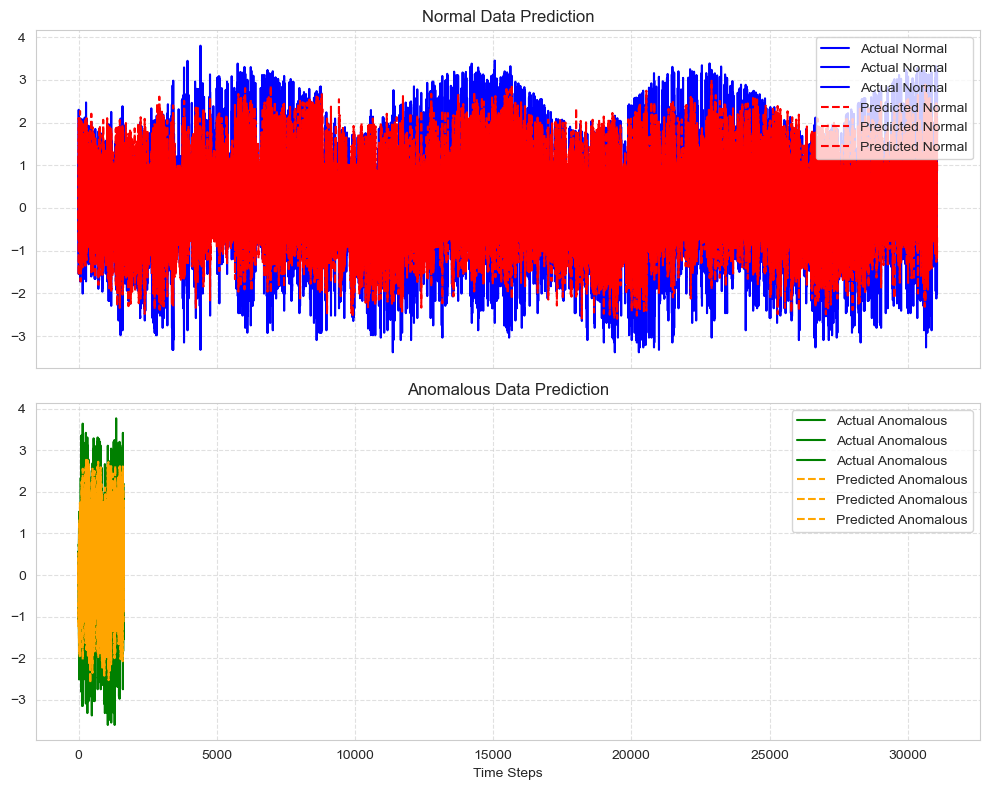

In [ ]:
y_pred_normal = model(torch.tensor(X_test_normal, dtype=torch.float32).to(device)).detach().cpu().numpy()
y_pred_anomaly = model(torch.tensor(X_test_anomaly, dtype=torch.float32).to(device)).detach().cpu().numpy()

fig, axes = plt.subplots(2, 1, figsize=(10, 8), sharex=True)

axes[0].plot(range(len(y_test_normal)), y_test_normal[:, 0], label="Actual Normal", color='blue', linestyle='-')
axes[0].plot(range(len(y_test_normal)), y_pred_normal[:, 0], label="Predicted Normal", color='red', linestyle='dashed')
axes[0].set_title("Normal Data Prediction")
axes[0].legend()
axes[0].grid(True, linestyle='--', alpha=0.6)

axes[1].plot(range(len(y_test_anomaly)), y_test_anomaly[:, 0], label="Actual Anomalous", color='green', linestyle='-')
axes[1].plot(range(len(y_test_anomaly)), y_pred_anomaly[:, 0], label="Predicted Anomalous", color='orange', linestyle='dashed')
axes[1].set_title("Anomalous Data Prediction")
axes[1].legend()
axes[1].grid(True, linestyle='--', alpha=0.6)

plt.xlabel("Time Steps")
plt.tight_layout()
plt.show()